# CSII 2024 Exercise 12: Q parametrization & Internal Model Control
© 2024 ETH Zurich, Joël Gmür, Felix Schnitzler, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

# Setup

In [1]:
# Install the required python library with pip
%pip install --upgrade cs2solutions
%pip install control==0.10.0

import numpy as np
import control as ct
import matplotlib.pyplot as plt
from cs2solutions import duckiebot

NameError: name 'unicycle_update' is not defined

# Exercise 1: Q-Parametrization for CS2-Bot Controller Design
Recall the CS2-Bot first used in Problem Set 03, where the advantages of state feedback were demonstrated. In Problem Set 04, we added a state estimator and introduced optimal control for it in Problem Set 05. In this problem set, the task is to parametrize all stabilizing controllers using a Q-parametrization.

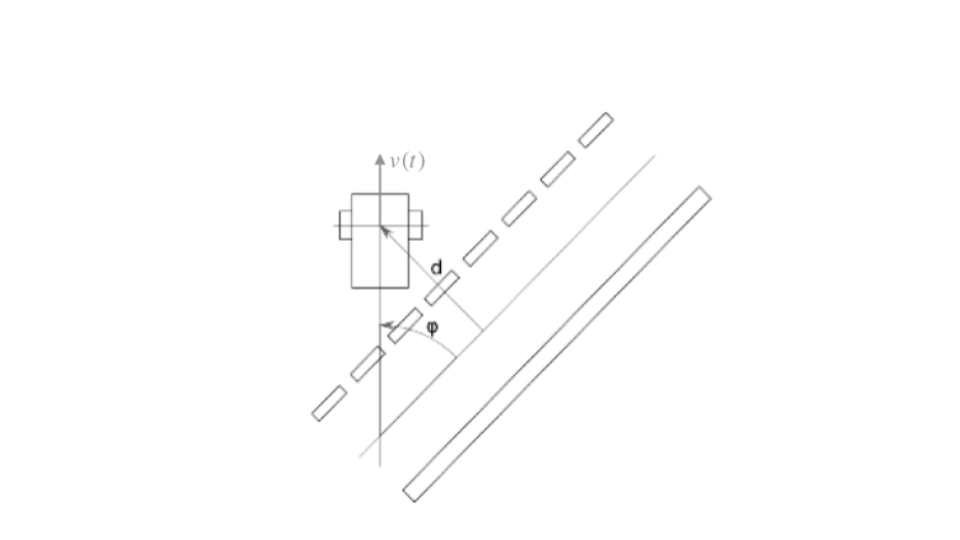

## Dynamics

The nonlinear dynamics and the output of the CS2-Bot are defined in the next cell.

In [ ]:
unicycle_update = duckiebot.unicycle_update
unicycle_output = duckiebot.unicycle_output

NameError: name 'duckiebot' is not defined

View function definitions by right-clicking and using 'Go to Definition (F12)'. Alternatively, you can view the function definitions on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/duckiebot.py#L13-L24).

Various plotting functions are defined here: [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/duckiebot.py#L27-L258)

## Parameters and Reference Track

We set a default CS2-Bot velocity and generate the nonlinear system using the `control` library.

In [ ]:
# Default CS2 Bot velocity in m/s
bot_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the CS2 Bot's steering dynamics as an input/output system
bot = ct.NonlinearIOSystem(
    duckiebot.unicycle_update, duckiebot.unicycle_output, states=3, name='bot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=bot_params)

v0 = bot_params['velocity']

NameError: name 'duckiebot' is not defined

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track, set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the else line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angular velocity `w_curvy`.

In [ ]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    bot, T_curvy, u_curvy, X0_curvy, params=bot_params, return_x=True)

duckiebot.plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell, we show you how to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.

In [ ]:
# Define the lateral dynamics as a subset of the full CS2 Bot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: duckiebot.unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: duckiebot.unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=bot_params)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C
D = lateral_linearized.D
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)

NameError: name 'duckiebot' is not defined

## Adding Noise

A certain type of noise will be affecting the system. Choose the noise type you would like to test in `index_noise`, where you change the integer number to the noise index you want to test. `index_noise = 0` corresponds to constant noise (i.e., a constant shift of the states), `index_noise = 1` is random uniform noise, `index_noise = 2` is white noise, and `index_noise = 3` is no noise.

In [ ]:
noise_type = ['const', 'uniform', 'white_noise', 'no_noise']
index_noise = 1
noise = noise_type[index_noise]
if noise == 'const':
    n = np.ones(r.shape)*0.5
elif noise=='uniform':
    n = np.random.uniform(low=-0.1, high=0.1, size=r.shape)
elif noise=='white_noise':
    Rw_lat = np.diag([0.001])
    n = ct.white_noise(t, Rw_lat)
else:
    n = np.zeros(r.shape)
U = np.concatenate((r, n))

## Implementing Q-Parametrization

Recall the structure of the Dynamic Output Feedback Compensator (DOFB) from Lecture 05. The following block diagram shows how Q-parametrization is introduced. The signal $v$ is the output, and the signal $h$ is the input to $Q$. In Lecture 05, we observed that the reference $r$ does not affect the innovation $ \eta = y - \hat{y} $. This implies that $v$ also has no influence on $h$ and thus the total system is stable if the parameter $Q$ is stable, assuming that the controller and the observer are stable on their own already.

In the following tasks, we will introduce the Q-parametrization to the DOFB from Lecture 05.

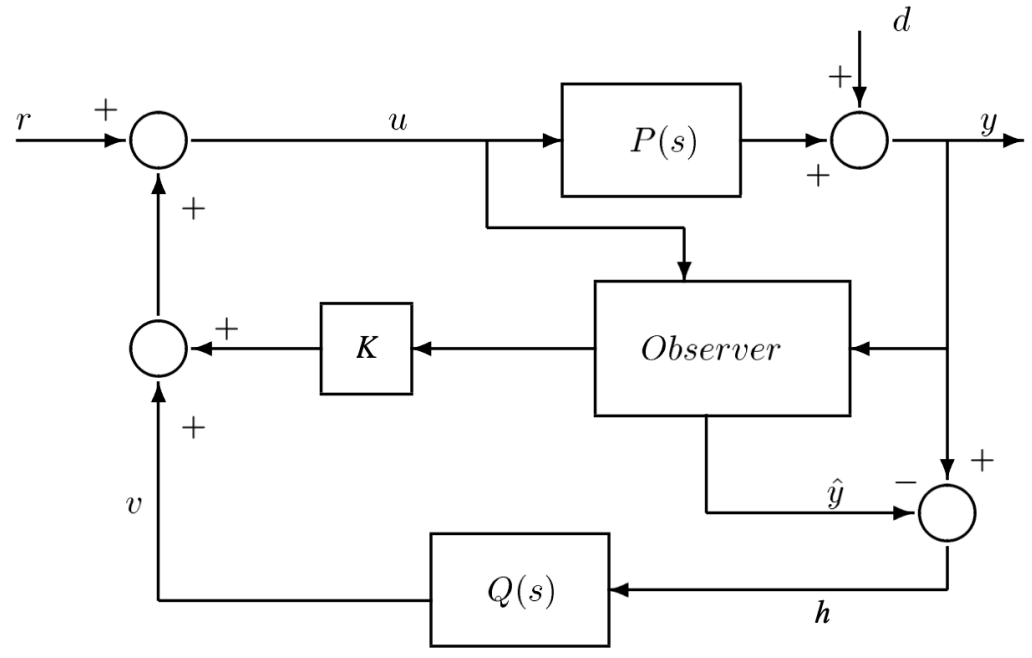

## Exercise 1.1 
Before we can introduce a $Q$-block, we need to find the transfer function of the plant $P$. For this, you can use the already computed system matrices $A$, $B$, $C$, and $D$.
Also, we need to set the state-feedback gain $K$ as well as the observer gain $L$.
You can use `ct.acker()` to place the poles.

In [ ]:
# Define the transfer function of the Plant P
P = ct.ss2tf(A,B,C,D)

# Setting the poles of the controller and observer
poles_controller = [-0.1, -0.1] # Try to change it
poles_observer = [-1, -1] # Try to change it

# Compute the controller and observer gains
K = ct.acker(A, B, poles_controller)
L = ct.acker(A.T, C.T, poles_observer).T

NameError: name 'A' is not defined

## Exercise 1.2
Next, we will need to define the $Q$-block. As seen in the lecture, $Q$ needs to be stable, proper, and rational.
Define the transfer function `Q` and the state-space representation `sys_q`. Print the poles to double-check the stability of $Q$.

Start with the transfer function
$$ Q = \frac{s}{s+1}.$$
After you have solved all parts of the exercise, you can come back and change the transfer function to see the effect on the stabilizing controller.

In [ ]:
# Define the transfer function for the parameter Q
Q = ct.TransferFunction([1, 0], [1, 1],name='Q')

# Compute the state-space representation of Q
sys_q = ct.tf2ss(Q)

# Compute the poles of Q and print the result
qpoles = ct.poles(Q)
print(qpoles)

## Exercise 1.3
Now that we have all the components of the system, we can compute the state-space representation of the full closed-loop system.

We receive the total state vector of the system by stacking the states of the Plant $P$, the states of the $Q$-Block and the innovation $\eta$:
$$ x_{cl} = \left [ \begin{array}{c} x \\ x_{Q} \\ \eta \end{array} \right]. $$

Recall that we can choose the $A$-matrices of the state-feedback subsystem and the observer subsystem with pole placement independently. This also applies to the $Q$-Block. Thus, you can compute the matrices for these subsystems individually before stacking them.

Compute the $A$-submatrices of the state-feedback and observer system, $ABK$ and $ALC$ respectively.

In [ ]:
# Find the A-matrix of the state-feedback subsystem
ABK = A - B @ K

# Find the A matrix of the observer subsystem
ALC = A - L @ C

## Exercise 1.4
Calculate the total closed-loop system matrices $A_{cl}$, $B_{cl}$, $C_{cl}$, $D_{cl}$. You can do this by concatenating the different terms that appear in the total closed loop system.

Hint: You will also need the terms $BC_Q$, $BK$ and $B_QC$.

In [ ]:
# Define the three additional matrices we need
BCQ = B @ sys_q.C
BK = B @ K
BQC = sys_q.B @ C

# Find the A matrix of the full closed loop system
#Concatenate the evaluated submatrices to find the first row of the total A matrix
Acl_1 = np.concatenate((ABK, BCQ, -BK), axis=1)

# Define the shape of the zeros-matrix at position (2,1)
zeros_21 = np.zeros((sys_q.A.shape[0], ABK.shape[1]))

#Concatenate the evaluated submatrices to find the second row of the total A matrix
Acl_2 = np.concatenate((zeros_21, sys_q.A, BQC), axis=1)

# Define the shape of the zeros-matrix at position (3, 1)
zeros_31 = np.zeros((ABK.shape[0], ABK.shape[1]))

# Define the shape of the zeros-matrix at position (3, 2)
zeros_32 = np.zeros((A.shape[0], sys_q.A.shape[1]))

#Concatenate the evaluated submatrices to find the third row of the total A matrix
Acl_3 = np.concatenate((zeros_31, zeros_32, ALC), axis=1)

# Concatenate the three evaluated rows to find the total A matrix
Acl = np.concatenate((Acl_1, Acl_2, Acl_3), axis=0)



# Find the B matrix of the full closed loop system
# Find the components of the first row of the total B matrix
B_11 = B
B_12 = np.zeros((ABK.shape[0], 1))

# Find the first row of the total B matrix
B_1 = np.concatenate((B_11, B_12), axis=1)

# Find the components of the first row of the total B matrix
B_21 = np.zeros((ABK.shape[0] + sys_q.A.shape[0], 1))
B_22 = np.ones((ABK.shape[0] + sys_q.A.shape[0], 1))

# Find the second row of the total B matrix
B_2 = np.concatenate((B_21, B_22), axis=1)

# Concatenate the three evaluated rows to find the total B matrix
Bcl = np.concatenate((B_1, B_2), axis=0)



# Find the C matrix of the full closed loop system
C_1 = np.zeros((1, Acl.shape[0]))
C_1[0][0] = 1
C_2 = np.concatenate((np.zeros((C.shape)), sys_q.C, np.zeros((C.shape))), axis=1)

# Concatenate the two evaluated rows to find the total C matrix
Ccl = np.concatenate((C_1, C_2), axis=0)



# Find the D matrix of the full closed loop system
Dcl = np.zeros((2, 2))



# Define the full closed loop system
syscl = ct.ss(Acl, Bcl, Ccl, Dcl)

# Print the full closed loop system
print(syscl)

NameError: name 'B' is not defined

The next code snippet simulates the response of the total system.

In [ ]:
x_0 = np.zeros((Acl.shape[0],))
x_0[0] = 0.2 #define initial position

t, yout, xf = ct.forced_response(syscl, T_curvy, U, X0 = x_0, return_x=True)
yf = yout[0]
v = yout[1]
omegaf = - K @ xf[:2] + y_ref + v
omegaf = omegaf[0]

Finally, we can visualize the performance of the system. 

In [ ]:
x_ref = x_curvy[0]
theta_ref = x_curvy[2]
omega_ref = w_curvy
y = np.array([yf])
omega = np.array([omegaf])

duckiebot.plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega, ['Test'])

Feel free to go back to the exercises and try different $Q$ transfer-functions, poles and iniatial conidtions. Try and observe the effects these changes have on the system by analyzing the plot.

# Exercise 2: Modern Control Synthesis

In this task, you will learn how you can use the `control` library to set up your plants for synthesizing a controller. To express performance and stability constraints, you will create frequency weights and compute the augmented generalized plant that can be further used with various methods to synthesize a controller.

## Plant definition

The plant used in this task models the linearized behavior of a simple inverted pendulum and is given as
$$P(s) = \frac{1}{s^2+0.1s-9.81}.$$

Note that this plant is unstable, and we will need to use a controller.

Initially, we define our controller $C(s)$ to do nothing, i.e., 
$$C(s) = 1.$$

In [18]:
P_s = ct.TransferFunction([1], [1, 0.1, -9.81], input='u', output='y', name='P(s)')
C_s = ct.TransferFunction([1], [1], input='e', output='u', name='C(s)')

print("Plant transfer function:")
display(P_s)
print("\nController transfer function:")
display(C_s)

Plant transfer function:


TransferFunction(array([1]), array([ 1.  ,  0.1 , -9.81]))


Controller transfer function:


TransferFunction(array([1]), array([1]))

We can easily check stability with `ct.poles` and see that the plant is unstable, having a pole with a positive real part.

In [19]:
ct.poles(P_s)

array([-3.18249102+0.j,  3.08249102+0.j])

## Frequency Weights

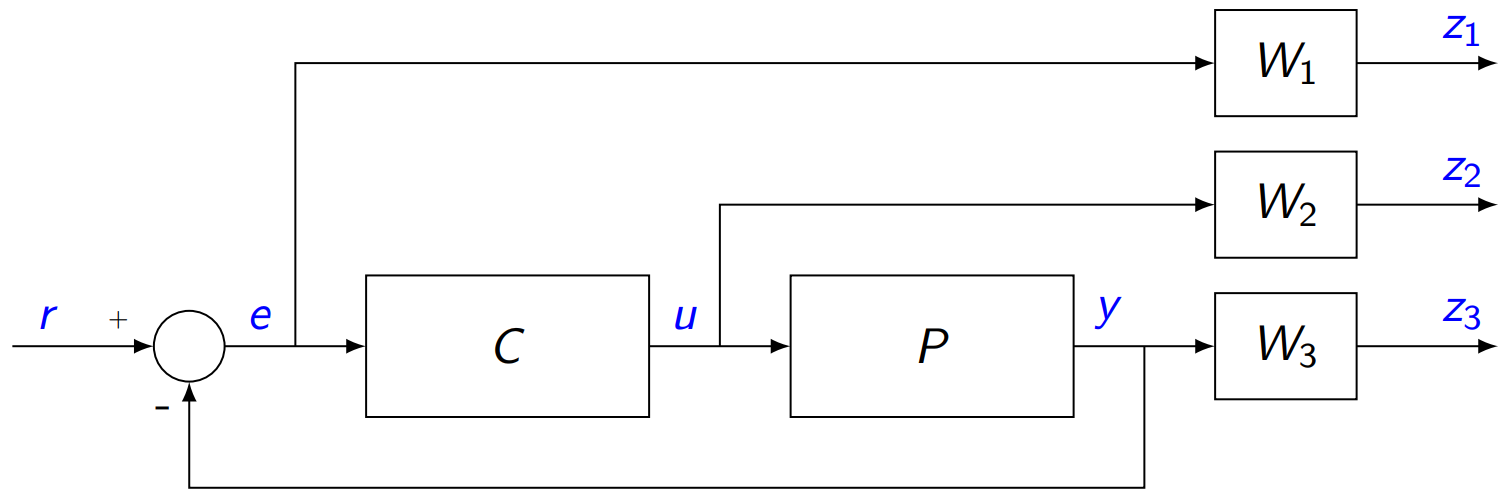


We want to create the two weights $W_1(s)$ and $W_3(s)$ to ensure reference tracking and noise attenuation.

Remember how we defined $W_1(s)$ and $W_3(s)$ in the lecture:
- $||W_1(s)S(s)|| << 1$ or $\sigma_{min}[L(s)] >> |W_1(s)|$
- $||W_3(s)T(s)|| <<$ 1 or $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$

Therefore, we want $W_1(s)$ to have very large magnitudes at low frequencies, and $W_3(s)$ to have large magnitudes at high frequencies.

Your first task is to implement functions that create our frequency weights with the definition from Lecture 9:
$$ W_1(s) = \frac{M}{Ms/\omega_1 + 1} \quad \text{and} \quad W_3(s) = \frac{Ms}{s + M\omega_3}.

In [20]:
def makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([1], [1], name='W_1')


def makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([1], [1], name='W_3')

Solutions

In [21]:
# Solutions
def solution_makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([M], [M/w1, 1], name='W_1')


def solution_makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([M, 0], [1, M*w3], name='W_3')

Now define the two weights such that:

- $W_1(s)$ has a magnitude of 100 at low frequencies, rolls off to zero at high frequencies, and has a magnitude of 1 at a frequency of $\omega_1 = 0.1 \text{rad/s}$,
- $W_3(s)$ approaches a magnitude of 100 at high frequencies, has a magnitude of 1 at a frequency of  $\omega_3 = 10\text{rad/s}$, and has a zero DC gain.

In [35]:
W_1 = solution_makeweight_1(1, 1)
W_3 = solution_makeweight_3(1, 1)


# Solutions
solution_W_1 = solution_makeweight_1(100, 0.1)
solution_W_3 = solution_makeweight_3(100, 10)

# Test
assert W_1 == solution_W_1, "W_1 is incorrect"
assert W_3 == solution_W_3, "W_3 is incorrect"

AssertionError: W_1 is incorrect

## Visualization of Frequency weights

Now, let us look at the singular value plots of these frequency weights and compare them to the open-loop transfer function $L(s)$. Since we want 
$\sigma_{min}[L(s)] >> |W_1(s)|$
and
$\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|},$
we will invert $W_3(s)$


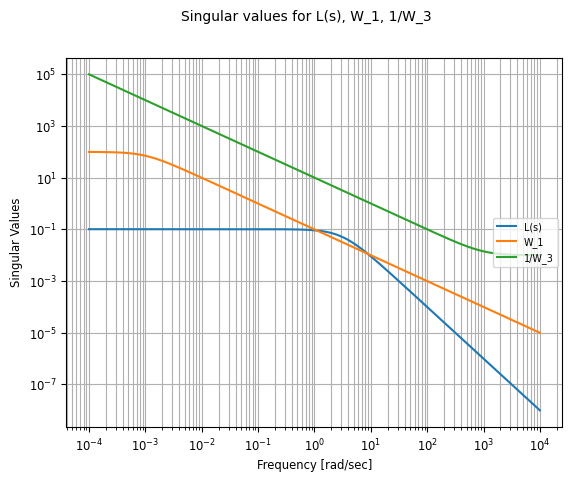

In [36]:
L_s = P_s * C_s
L_s.name = 'L(s)'

W_3_inverted = 1 / W_3
W_3_inverted.name = '1/W_3'

_ = ct.singular_values_plot([L_s, solution_W_1, W_3_inverted])

## Assembly of the generalized plant

We want the open-loop transfer function $L(s)$ to lie between the upper and lower bounds given by $W_1(s)$ and $W_3(s)$ respectively. Note that we are dealing with a SISO system and therefore get only one singular value, implying $\sigma_{min}[L(s)] = \sigma_{max}[L(s)]$.

This loop shaping problem boils down to finding a controller $C(s)$ that places $L(s)$ between our bounds $W_1(s)$ and $W_3(s)$. We want to find the generalized plant
$$ G(s) = \begin{bmatrix} G_{zw}(s) & G_{zu}(s) \\ G_{yw}(s) & G_{yu}(s) \end{bmatrix},$$

which we can then use in an optimization problem to synthesize our controller $C(s)$.

One could derive each transfer function by hand and would find that
$$ G(s) = \begin{bmatrix} W_1(s) & -W_1(s)P(s) \\ 0 & W_3(s)P(s) \end{bmatrix},$$

or we can use the function `ct.augw(g, w1, w2, w3)` from the `control` library. \
**Caution:** due to a different nomenclature, `g` corresponds to the plant $P(s)$ and **NOT** the generalized plant $G(s)$!

In [37]:
G_s = ct.augw(P_s, w1=W_1, w2=None, w3=W_3)

display(G_s)

StateSpace(array([[-1.00e-03,  0.00e+00,  0.00e+00,  1.00e-01],
       [ 0.00e+00, -1.00e+03,  0.00e+00, -1.00e+01],
       [ 0.00e+00,  0.00e+00, -1.00e-01,  9.81e-01],
       [ 0.00e+00,  0.00e+00,  1.00e+01,  0.00e+00]]), array([[ 1.,  0.],
       [ 0.,  0.],
       [ 0., -1.],
       [ 0.,  0.]]), array([[ 1.e-01,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e+03,  0.e+00, -1.e+01],
       [ 0.e+00,  0.e+00,  0.e+00,  1.e-01]]), array([[0., 0.],
       [0., 0.],
       [1., 0.]]))

Now we can use, for example, $H_2$ optimal control to synthesize our controller.